In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD


from art.estimators.classification.deep_partition_ensemble import DeepPartitionEnsemble

# Load the Data

In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

# Poison training data
percent_poison = .33
x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)

x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

# Initialize the Model Architecture

In [3]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
def create_model():    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Set up the Model Backdoor

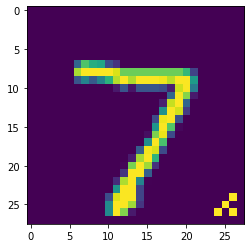

In [4]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pdata, plabels = backdoor.poison(x_test, y=example_target)

plt.imshow(pdata[0].squeeze())

# Create the poison data
For this example, we will select 9 as the target class. Thus, the adversary's goal is to poison the model so adding a trigger will result in the trained model misclassifying the triggered input as a 9.

First, the adversary will create a proxy classifier (i.e., a classifier that is similar to the target classifier). As the clean label attack generates noise using PGD in order to encourage the trained classifier to rely on the trigger, it is important that the generated noise be transferable. Thus, adversarial training is used.

In [5]:
# Poison some percentage of all non-nines to nines
targets = to_categorical([9], 10)[0] 

proxy = AdversarialTrainerMadryPGD(KerasClassifier(create_model()), nb_epochs=10, eps=0.15, eps_step=0.001)
proxy.fit(x_train, y_train)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor, proxy_classifier=proxy.get_classifier(),
                                           target=targets, pp_poison=percent_poison, norm=2, eps=5,
                                           eps_step=0.1, max_iter=200)
pdata, plabels = attack.poison(x_train, y_train)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

1042


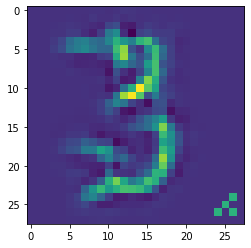

Index: 290 Label: 9


In [7]:
poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]
print(len(poisoned))
for i in range(len(poisoned)):
    if poisoned[i][0][0] != 0:
        plt.imshow(poisoned[i].squeeze())
        plt.show()
        print(f"Index: {i} Label: {np.argmax(poisoned_labels[i])}")
        break

# Initialize the classification models
We will initialize four models. The first is a single model architecture. The other three are DPA models with varying ensemble sizes to demonstrate the tradeoff between clean accuracy and poison accuracy. This make take some time because of the model copying.

In [8]:
model = KerasClassifier(create_model())
dpa_model_10 = DeepPartitionEnsemble(model, ensemble_size=10)
dpa_model_20 = DeepPartitionEnsemble(model, ensemble_size=20)
dpa_model_30 = DeepPartitionEnsemble(model, ensemble_size=30)


Train the models on the poisoned data

In [9]:
model.fit(pdata, plabels, nb_epochs=10)
dpa_model_10.fit(pdata, plabels, nb_epochs=10)
dpa_model_20.fit(pdata, plabels, nb_epochs=10)
dpa_model_30.fit(pdata, plabels, nb_epochs=10)

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 109us/sample - loss: 0.6668 - accuracy: 0.7935
Epoch 2/10
10000/10000 [==============================] - 1s 53us/sample - loss: 0.2129 - accuracy: 0.9366
Epoch 3/10
10000/10000 [==============================] - 1s 54us/sample - loss: 0.1514 - accuracy: 0.9544
Epoch 4/10
10000/10000 [==============================] - 1s 53us/sample - loss: 0.1092 - accuracy: 0.9691
Epoch 5/10
10000/10000 [==============================] - 1s 52us/sample - loss: 0.0860 - accuracy: 0.9740
Epoch 6/10
10000/10000 [==============================] - 1s 52us/sample - loss: 0.0668 - accuracy: 0.9794
Epoch 7/10
10000/10000 [==============================] - 1s 52us/sample - loss: 0.0636 - accuracy: 0.9789
Epoch 8/10
10000/10000 [==============================] - 1s 52us/sample - loss: 0.0554 - accuracy: 0.9822
Epoch 9/10
10000/10000 [==============================] - 1s 54us/sample - loss: 0.0441 - accuracy: 0.9871
Epoch 10/10
1

968/968 [==============================] - 0s 55us/sample - loss: 0.2729 - accuracy: 0.9070
Epoch 8/10
968/968 [==============================] - 0s 56us/sample - loss: 0.2170 - accuracy: 0.9277
Epoch 9/10
968/968 [==============================] - 0s 60us/sample - loss: 0.1661 - accuracy: 0.9473
Epoch 10/10
968/968 [==============================] - 0s 55us/sample - loss: 0.1444 - accuracy: 0.9473
Train on 986 samples
Epoch 1/10
986/986 [==============================] - 9s 10ms/sample - loss: 1.8995 - accuracy: 0.3793
Epoch 2/10
986/986 [==============================] - 0s 57us/sample - loss: 0.9369 - accuracy: 0.6876
Epoch 3/10
986/986 [==============================] - 0s 60us/sample - loss: 0.6742 - accuracy: 0.7769
Epoch 4/10
986/986 [==============================] - 0s 54us/sample - loss: 0.5473 - accuracy: 0.8479
Epoch 5/10
986/986 [==============================] - 0s 53us/sample - loss: 0.4056 - accuracy: 0.8763
Epoch 6/10
986/986 [==============================] - 0s 57us/

528/528 [==============================] - 0s 60us/sample - loss: 0.8397 - accuracy: 0.7273
Epoch 5/10
528/528 [==============================] - 0s 62us/sample - loss: 0.7018 - accuracy: 0.7386
Epoch 6/10
528/528 [==============================] - 0s 60us/sample - loss: 0.6145 - accuracy: 0.7973
Epoch 7/10
528/528 [==============================] - 0s 58us/sample - loss: 0.5095 - accuracy: 0.8371
Epoch 8/10
528/528 [==============================] - 0s 59us/sample - loss: 0.4645 - accuracy: 0.8295
Epoch 9/10
528/528 [==============================] - 0s 60us/sample - loss: 0.4049 - accuracy: 0.8712
Epoch 10/10
528/528 [==============================] - 0s 57us/sample - loss: 0.3533 - accuracy: 0.8864
Train on 505 samples
Epoch 1/10
505/505 [==============================] - 10s 20ms/sample - loss: 2.1431 - accuracy: 0.2337
Epoch 2/10
505/505 [==============================] - 0s 58us/sample - loss: 1.5446 - accuracy: 0.5564
Epoch 3/10
505/505 [==============================] - 0s 55us

534/534 [==============================] - 10s 19ms/sample - loss: 2.1621 - accuracy: 0.2154
Epoch 2/10
534/534 [==============================] - 0s 70us/sample - loss: 1.5126 - accuracy: 0.5056
Epoch 3/10
534/534 [==============================] - 0s 64us/sample - loss: 1.0817 - accuracy: 0.6217
Epoch 4/10
534/534 [==============================] - 0s 63us/sample - loss: 0.7903 - accuracy: 0.7509
Epoch 5/10
534/534 [==============================] - 0s 60us/sample - loss: 0.6815 - accuracy: 0.7884
Epoch 6/10
534/534 [==============================] - 0s 60us/sample - loss: 0.5505 - accuracy: 0.8296
Epoch 7/10
534/534 [==============================] - 0s 59us/sample - loss: 0.5044 - accuracy: 0.8446
Epoch 8/10
534/534 [==============================] - 0s 59us/sample - loss: 0.4086 - accuracy: 0.8727
Epoch 9/10
534/534 [==============================] - 0s 59us/sample - loss: 0.3429 - accuracy: 0.9064
Epoch 10/10
534/534 [==============================] - 0s 58us/sample - loss: 0.305

483/483 [==============================] - 0s 55us/sample - loss: 0.3106 - accuracy: 0.9110
Epoch 10/10
483/483 [==============================] - 0s 55us/sample - loss: 0.2805 - accuracy: 0.9110
Train on 324 samples
Epoch 1/10
324/324 [==============================] - 11s 33ms/sample - loss: 2.2548 - accuracy: 0.1420
Epoch 2/10
324/324 [==============================] - 0s 67us/sample - loss: 1.8664 - accuracy: 0.4753
Epoch 3/10
324/324 [==============================] - 0s 61us/sample - loss: 1.4684 - accuracy: 0.5864
Epoch 4/10
324/324 [==============================] - 0s 69us/sample - loss: 1.1296 - accuracy: 0.6265
Epoch 5/10
324/324 [==============================] - 0s 63us/sample - loss: 0.8679 - accuracy: 0.7160
Epoch 6/10
324/324 [==============================] - 0s 61us/sample - loss: 0.7579 - accuracy: 0.7500
Epoch 7/10
324/324 [==============================] - 0s 60us/sample - loss: 0.7367 - accuracy: 0.7562
Epoch 8/10
324/324 [==============================] - 0s 63us

308/308 [==============================] - 0s 63us/sample - loss: 0.7043 - accuracy: 0.7500
Epoch 7/10
308/308 [==============================] - 0s 64us/sample - loss: 0.5364 - accuracy: 0.8247
Epoch 8/10
308/308 [==============================] - 0s 64us/sample - loss: 0.4573 - accuracy: 0.8539
Epoch 9/10
308/308 [==============================] - 0s 65us/sample - loss: 0.4340 - accuracy: 0.8506
Epoch 10/10
308/308 [==============================] - 0s 64us/sample - loss: 0.3776 - accuracy: 0.8734
Train on 335 samples
Epoch 1/10
335/335 [==============================] - 11s 34ms/sample - loss: 2.2041 - accuracy: 0.1881
Epoch 2/10
335/335 [==============================] - 0s 69us/sample - loss: 1.7178 - accuracy: 0.5134
Epoch 3/10
335/335 [==============================] - 0s 63us/sample - loss: 1.2325 - accuracy: 0.6418
Epoch 4/10
335/335 [==============================] - 0s 62us/sample - loss: 0.9610 - accuracy: 0.6955
Epoch 5/10
335/335 [==============================] - 0s 62us

330/330 [==============================] - 0s 62us/sample - loss: 1.3075 - accuracy: 0.6303
Epoch 4/10
330/330 [==============================] - 0s 63us/sample - loss: 0.9618 - accuracy: 0.7091
Epoch 5/10
330/330 [==============================] - 0s 63us/sample - loss: 0.7600 - accuracy: 0.7576
Epoch 6/10
330/330 [==============================] - 0s 64us/sample - loss: 0.6339 - accuracy: 0.7848
Epoch 7/10
330/330 [==============================] - 0s 65us/sample - loss: 0.5387 - accuracy: 0.8182
Epoch 8/10
330/330 [==============================] - 0s 62us/sample - loss: 0.4587 - accuracy: 0.8576
Epoch 9/10
330/330 [==============================] - 0s 61us/sample - loss: 0.3809 - accuracy: 0.8848
Epoch 10/10
330/330 [==============================] - 0s 67us/sample - loss: 0.3699 - accuracy: 0.8697
Train on 318 samples
Epoch 1/10
318/318 [==============================] - 12s 37ms/sample - loss: 2.1802 - accuracy: 0.2013
Epoch 2/10
318/318 [==============================] - 0s 71us

Epoch 1/10
364/364 [==============================] - 1s 2ms/sample - loss: 2.1992 - accuracy: 0.2308
Epoch 2/10
364/364 [==============================] - 0s 61us/sample - loss: 1.7003 - accuracy: 0.5412
Epoch 3/10
364/364 [==============================] - 0s 64us/sample - loss: 1.2034 - accuracy: 0.6538
Epoch 4/10
364/364 [==============================] - 0s 62us/sample - loss: 0.8895 - accuracy: 0.7170
Epoch 5/10
364/364 [==============================] - 0s 61us/sample - loss: 0.7179 - accuracy: 0.7637
Epoch 6/10
364/364 [==============================] - 0s 62us/sample - loss: 0.5412 - accuracy: 0.8324
Epoch 7/10
364/364 [==============================] - 0s 62us/sample - loss: 0.4449 - accuracy: 0.8654
Epoch 8/10
364/364 [==============================] - 0s 60us/sample - loss: 0.3979 - accuracy: 0.8819
Epoch 9/10
364/364 [==============================] - 0s 62us/sample - loss: 0.3312 - accuracy: 0.9038
Epoch 10/10
364/364 [==============================] - 0s 60us/sample - lo

# Evaluate the performance of the trained models on unpoisoned data
The performance of the models appears normal. We see that for the DPA models, the performance drops slightly as the ensemble size increases


Clean test set accuracy (model): 98.01%


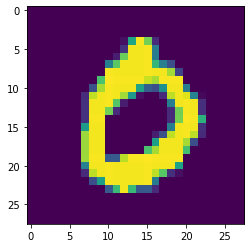

Prediction: 0


In [10]:
clean_preds = np.argmax(model.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (model): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model_10): 93.94%


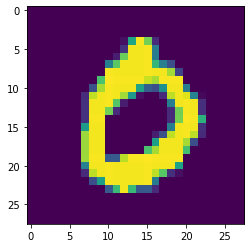

Prediction: 0


In [11]:
clean_preds = np.argmax(dpa_model_10.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_10): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model_20): 91.32%


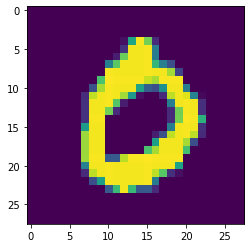

Prediction: 0


In [12]:
clean_preds = np.argmax(dpa_model_20.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_20): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

In [ ]:
clean_preds = np.argmax(dpa_model_30.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_30): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

# Evaluate the performance of the trained models on poisoned data
When the trigger is added, we see a shift in performance. The single model performs the worst as no defense is in place to mitigate the effect of the poisoned. The DPA models show some robustnesss to the poison as they partition the training data, which spreads the effect of the poison between models in the ensemble.

In [ ]:
not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])

poison_preds = np.argmax(model.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (model): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))

In [ ]:
poison_preds = np.argmax(dpa_model_10.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_10): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))

In [ ]:
poison_preds = np.argmax(dpa_model_20.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_20): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))

In [ ]:
poison_preds = np.argmax(dpa_model_30.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_30): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))